In [84]:
# Import

# General
import os
import pandas as pd
import numpy as np
import pickle
from collections import Counter
import sys
import copy
import glob

# Import helper functions
from evaluation_helper import *

# Add our pipeline folder to the path to import functions
sys.path.insert(1, '../2_modeling')
from model_helper import *

#Plotting
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
import matplotlib.image as mpimg
%matplotlib inline

# Data Processing
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.metrics import roc_curve, auc

# Machine Learning
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras.applications.vgg19 import VGG19
from tensorflow.keras import backend as K



# List the files of saved models


In [85]:
# Paths
models_path = '../../efs/models'
checkpoint_path='../../efs/models/Checkpoints/'
training_history_path='../../efs/models/Training_history/'
saved_models_path='../../efs/models/Saved_models/'

In [86]:
# os.listdir(checkpoint_path)

In [87]:
# os.listdir(training_history_path)

In [96]:
def check_number_of_epochs(min_number_of_epochs, path):
    """ check to see if the history has at least a certain number of epochs and for a certain sample size"""    
    
    frame = pd.read_csv(path)
    
    if frame.shape[0] > min_number_of_epochs:
        return True
    
    return False

In [97]:
# Grab all the paths and create a dictionary of dataframes with the name as the key
csv_history_paths = glob.glob(training_history_path+'*.csv')

#filter for only that have 'all' samples
csv_history_paths_all = [path for path in csv_history_paths if path.find('all')!=-1]

minimum_number_of_epochs = 10

histories = dict()

for path in csv_history_paths_all:
    try:
        if check_number_of_epochs(minimum_number_of_epochs, path):
            histories[grab_model_name(path)] = pd.read_csv(path)
    except:
        pass

In [98]:
for path in csv_history_paths_all:
    print(grab_model_name(path))

model2_sample_sizeall_epoch50_dense2_losswbc_history_log
model_no_cache_test_sample_size_all_epoch_20_dense_2_neurons_512_losswbc__num_open_layers_2_penalty_weight_10_history_log
model_no_cache_test_sample_size_all_epoch_2_dense_2_neurons_256_losswbc__num_open_layers_1_penalty_weight_10_history_log
model_ALL_FEATURES_sample_size_all_epoch_20_dense_2_neurons_1024_losswbc__num_open_layers_2_penalty_weight_10_history_log
model_Multi_input_sample_size_all_epoch_30_dense_2_neurons_1024_losswbc__num_open_layers_2_penalty_weight_10_history_log
model_no_cache_test_sample_size_all_epoch_1_dense_2_neurons_512_losswbc__num_open_layers_2_penalty_weight_10_sanity_check_history_log


In [99]:
csv_history_paths_all[5]

'../../efs/models/Training_history/model_no_cache_test_sample_size_all_epoch_1_dense_2_neurons_512_losswbc__num_open_layers_2_penalty_weight_10_sanity_check_history_log.csv'

In [101]:
histories

{'model_no_cache_test_sample_size_all_epoch_20_dense_2_neurons_512_losswbc__num_open_layers_2_penalty_weight_10_history_log':     epoch  accuracy_on_one  accuracy_on_zero      loss  precision_on_1  \
 0       0         0.785456          0.737177  0.870815        0.209442   
 1       1         0.850098          0.834998  0.653782        0.302040   
 2       2         0.867129          0.855545  0.583702        0.334774   
 3       3         0.877663          0.864543  0.545095        0.351961   
 4       4         0.885210          0.870485  0.517701        0.364226   
 5       5         0.892028          0.874809  0.497273        0.373914   
 6       6         0.896211          0.878257  0.480676        0.381603   
 7       7         0.900272          0.881317  0.466738        0.388698   
 8       8         0.904056          0.883803  0.453981        0.394751   
 9       9         0.907389          0.886266  0.442857        0.400766   
 10     10         0.910341          0.888136  0.4

In [102]:
check_number_of_epochs_and_sample_size(10, csv_history_paths[7])

False

In [103]:
for path in csv_history_paths:
    print(path)
#     check_number_of_epochs_and_sample_size(10,path)

../../efs/models/Training_history/model2_sample_sizeall_epoch50_dense2_losswbc_history_log.csv
../../efs/models/Training_history/model_no_cache_test_sample_size_14000_epoch_2_dense_2_neurons_256_losswbc__num_open_layers_1_penalty_weight_10_history_log.csv
../../efs/models/Training_history/model_no_cache_test_sample_size_all_epoch_20_dense_2_neurons_512_losswbc__num_open_layers_2_penalty_weight_10_history_log.csv
../../efs/models/Training_history/model__sample_size_15000_epoch_20_dense_2_neurons_1024_losswbc__num_open_layers_1_penalty_weight_10_history_log.csv
../../efs/models/Training_history/model__sample_size_500_epoch_20_dense_2_neurons_1024_losswbc__num_open_layers_2_penalty_weight_10featuresextended_history_log.csv
../../efs/models/Training_history/model_no_cache_test_sample_size_all_epoch_2_dense_2_neurons_256_losswbc__num_open_layers_1_penalty_weight_10_history_log.csv
../../efs/models/Training_history/model_ALL_FEATURES_sample_size_all_epoch_20_dense_2_neurons_1024_losswbc__num

In [104]:
# Create a list of all the datframes with the correct columns
list_of_dfs = [frame_extraction(histories[path], path) for path in list(histories.keys())]
all_models = pd.concat(list_of_dfs)

In [105]:
# Change all the model names to something comprehensible
old_names = all_models.model.unique()
new_names = ['Single Input with 2 Dense Layers 512 Neurons and 2 open layers',
            'Single Input with 2 Dense Layers 1024 Neurons and 2 open layers',
            'Multiple Input with 2 Dense Layers 1024 Neurons and 2 open layers']

for new,old in zip(new_names, old_names):
    all_models.replace(old, new, inplace=True)

In [106]:
all_models.columns

Index(['epoch', 'val_precision_on_1', 'val_accuracy_on_zero',
       'val_accuracy_on_one', 'model', 'f1'],
      dtype='object')

Text(0, 0.5, 'Validation recall on zero')

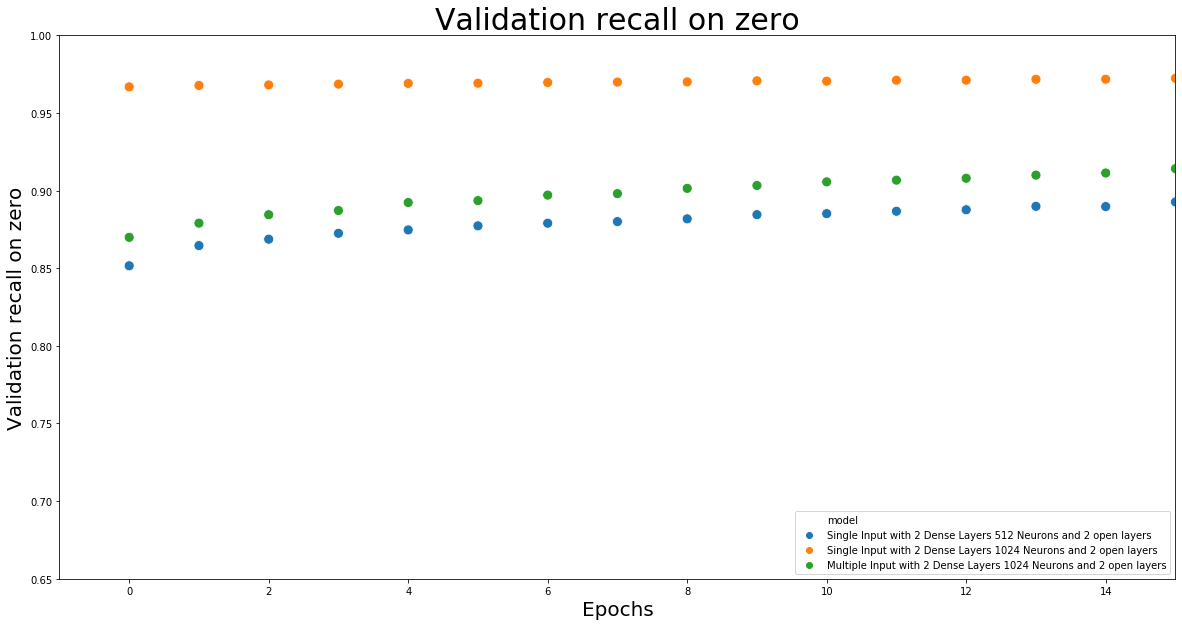

In [107]:
fig, ax = plt.subplots(figsize=(20, 10))
sns.scatterplot(x='epoch', 
                y="val_accuracy_on_zero", 
                hue="model",
                s=100,
                data=all_models, ax=ax)
plt.legend(loc='lower right')
ax.set_xlim((-1,15))
ax.set_ylim((.65,1))
font_title={'size':30}
plt.title("Validation recall on zero", font_title)
font_axes={'size':20}
ax.set_xlabel("Epochs", font_axes)
ax.set_ylabel("Validation recall on zero", font_axes)

Text(0, 0.5, 'Validation recall')

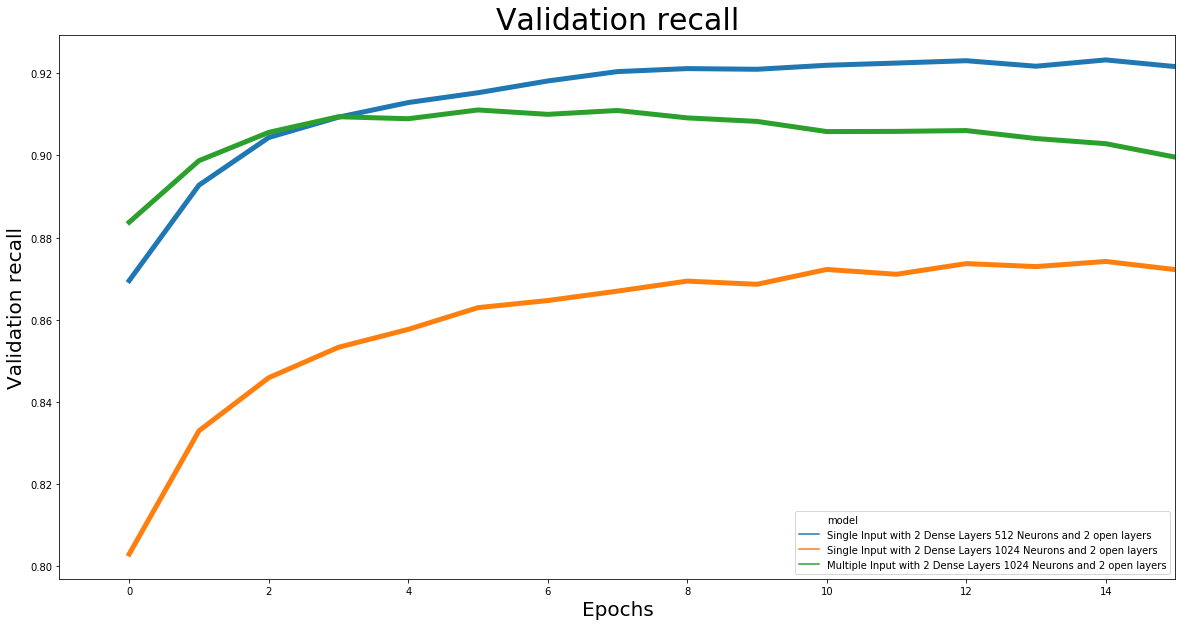

In [108]:
fig, ax = plt.subplots(figsize=(20, 10))
sns.lineplot(x='epoch', y="val_accuracy_on_one", hue="model",
                     data=all_models, ax=ax, lw=5)
ax.set_xlim((-1,15))
plt.title("Validation recall", font_title)
font_axes={'size':20}
ax.set_xlabel("Epochs", font_axes)
ax.set_ylabel("Validation recall", font_axes)

Text(0, 0.5, 'Validation precision')

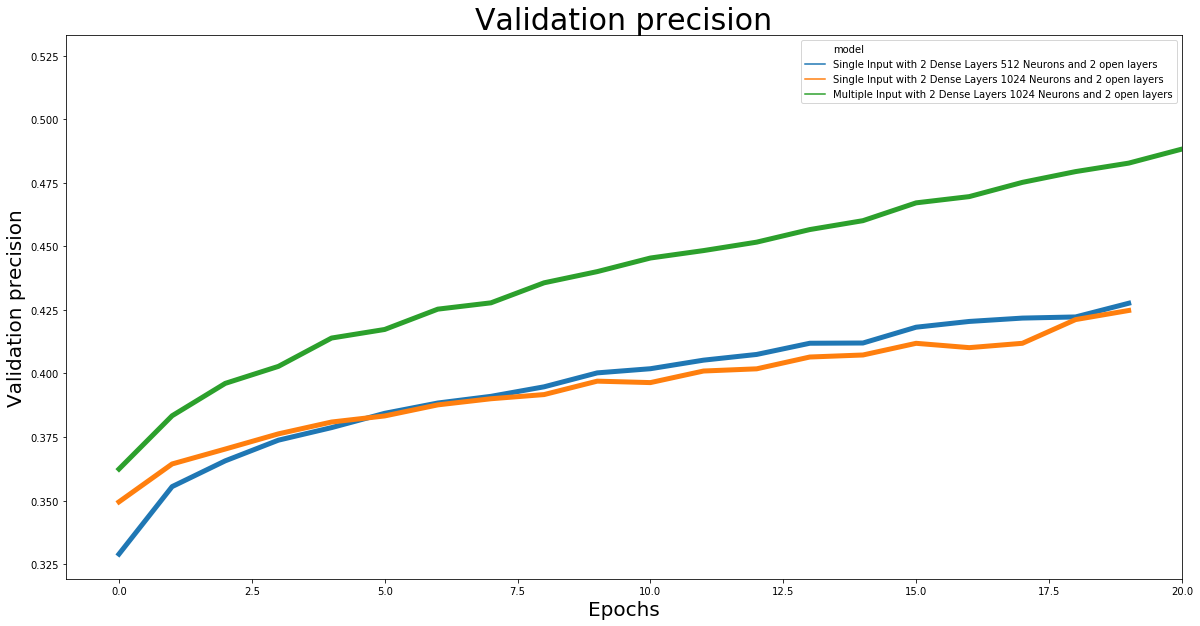

In [109]:
fig, ax = plt.subplots(figsize=(20, 10))
sns.lineplot(x='epoch', y="val_precision_on_1", hue="model",
                     data=all_models, ax=ax, lw=5)

ax.set_xlim((-1,20))

plt.title("Validation precision", font_title)
font_axes={'size':20}
ax.set_xlabel("Epochs", font_axes)
ax.set_ylabel("Validation precision", font_axes)

Text(0, 0.5, 'F1')

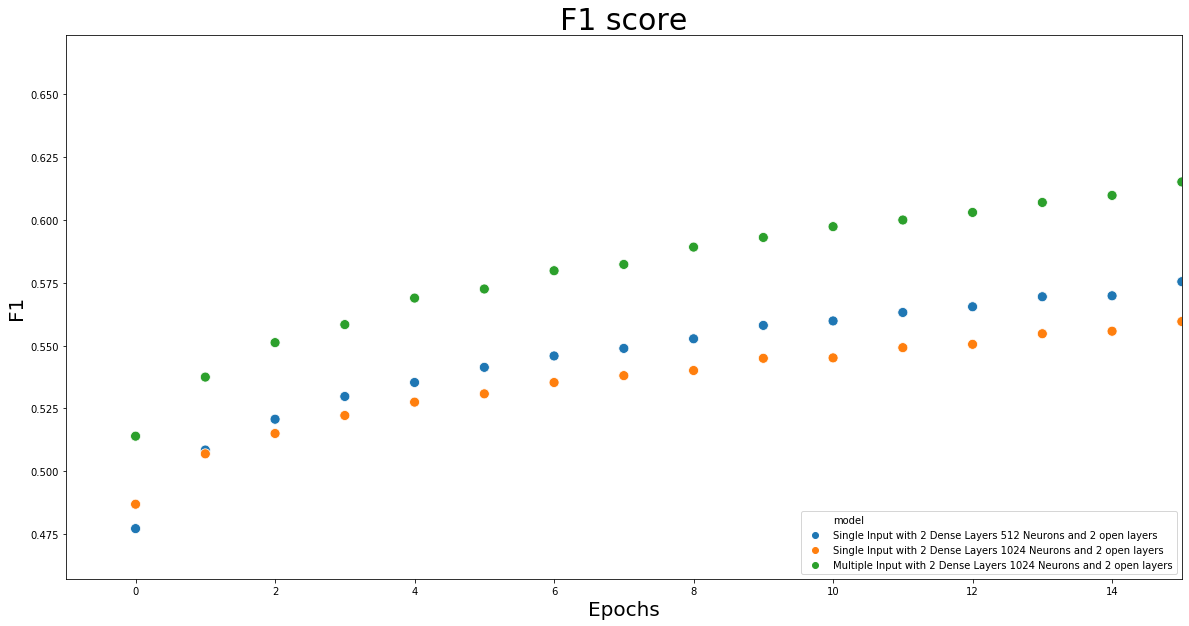

In [110]:
fig, ax = plt.subplots(figsize=(20, 10))
sns.scatterplot(x='epoch', 
                y="f1", 
                hue="model",
                s=100,
                data=all_models, ax=ax)
plt.legend(loc='lower right')
ax.set_xlim((-1,15))
font_title={'size':30}
plt.title("F1 score", font_title)
font_axes={'size':20}
ax.set_xlabel("Epochs", font_axes)
ax.set_ylabel("F1", font_axes)